# This is the start of the complete unsupervised notebook with PID

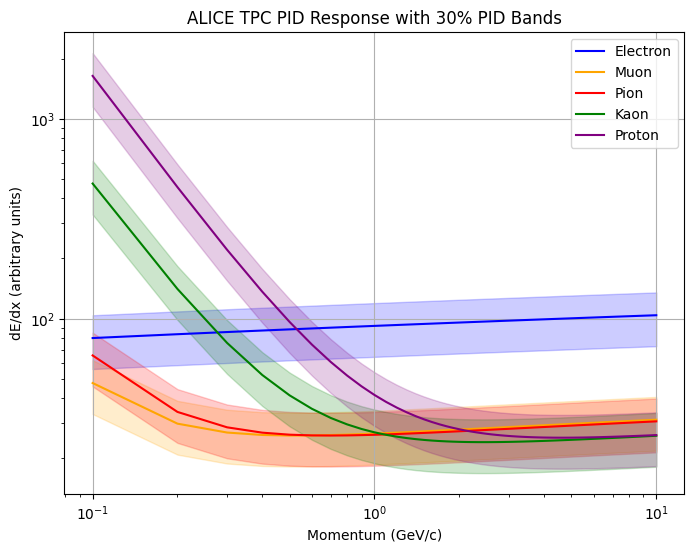

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def bethe_bloch(momentum, mass, charge=1):
    """
    Parametrizes the Bethe-Bloch formula for energy loss in the TPC.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - mass: Particle mass (GeV/c^2)
    - charge: Particle charge (default = 1)
    
    Returns:
    - dE/dx: Energy loss per unit distance (arbitrary units)
    """
    # Constants for Bethe-Bloch approximation
    K = 0.307075  # MeV mol^-1 cm^2
    Z = charge  # Particle charge
    I = 0.000016  # Mean excitation potential (MeV)
    m_e = 0.511  # Electron mass in MeV/c^2
    rho = 1  # Density of the material (relative to water, for simplicity)

    # Relativistic terms
    beta = momentum / np.sqrt(momentum**2 + mass**2)
    gamma = 1 / np.sqrt(1 - beta**2)
    
    # Bethe-Bloch equation (simplified)
    dEdx = ((K * Z**2 * rho) / (beta**2) * (0.5 * np.log(2 * m_e * beta**2 * gamma**2 / I**2) - beta**2)) * 17
    
    return dEdx

def tpc_pid_response(momentum, particle_type, stretch_factor=1):
    """
    Provides a parametrized TPC PID response for different particle types with a 30% PID band.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    
    Returns:
    - dE/dx: TPC PID response (arbitrary units)
    - lower_band: Lower bound of PID band (70% of dE/dx)
    - upper_band: Upper bound of PID band (130% of dE/dx)
    """
    mass_dict = {
        'electron': 0.000511,
        'muon': 0.10566,
        'pion': 0.13957,
        'kaon': 0.49367,
        'proton': 0.93827
    }
    
    mass = mass_dict.get(particle_type, 0.13957)  # Default to pion mass if not found
    dEdx = bethe_bloch(momentum, mass) * stretch_factor
    lower_band = dEdx * 0.7
    upper_band = dEdx * 1.3
    
    return dEdx, lower_band, upper_band

def error_extremes(momentum, particle_type, stretch_factor):
    """
    Helper function to return error band extremes for a given particle type.
    """
    _, lower_band, upper_band = tpc_pid_response(momentum, particle_type, stretch_factor)
    return upper_band, lower_band

def plot_tpc_pid_response(momentum_range):
    """
    Plot the TPC PID response and error bands for various particle types.
    """
    # Calculate responses and PID bands for different particle species
    particle_types = {
        'Electron': {'color': 'blue', 'stretch_factor': 1},
        'Muon': {'color': 'orange', 'stretch_factor': 0.41},
        'Pion': {'color': 'red', 'stretch_factor': 0.41},
        'Kaon': {'color': 'green', 'stretch_factor': 0.38},
        'Proton': {'color': 'purple', 'stretch_factor': 0.4}
    }
    
    plt.figure(figsize=(8, 6))
    
    for particle, settings in particle_types.items():
        response, lower_band, upper_band = tpc_pid_response(momentum_range, particle.lower(), settings['stretch_factor'])
        plt.plot(momentum_range, response, label=particle, color=settings['color'])
        plt.fill_between(momentum_range, lower_band, upper_band, color=settings['color'], alpha=0.2)
    
    plt.xlabel('Momentum (GeV/c)')
    plt.ylabel('dE/dx (arbitrary units)')
    plt.xscale('log')  # Log scale for x-axis
    plt.yscale('log')  # Log scale for y-axis
    plt.title('ALICE TPC PID Response with 30% PID Bands')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate a momentum range and plot
momentum_range = np.linspace(0.1, 10, 100)  # Momentum range from 0.1 to 10 GeV/c
plot_tpc_pid_response(momentum_range)


In [12]:
# Example usage
momentum_value = 1  # Example momentum value in GeV/c

# Get error band extremes for different particles
for particle in ['electron', 'proton', 'muon', 'pion', 'kaon']:
    max_band, min_band = error_extremes(momentum_value, particle, stretch_factor=1)
    print(f"At momentum {momentum_value} GeV/c for {particle.capitalize()}:")
    print(f"Maximum of error band: {max_band:.4f}")
    print(f"Minimum of error band: {min_band:.4f}")


At momentum 1 GeV/c for Electron:
Maximum of error band: 119.6635
Minimum of error band: 64.4342
At momentum 1 GeV/c for Proton:
Maximum of error band: 135.0813
Minimum of error band: 72.7361
At momentum 1 GeV/c for Muon:
Maximum of error band: 84.4890
Minimum of error band: 45.4941
At momentum 1 GeV/c for Pion:
Maximum of error band: 83.3139
Minimum of error band: 44.8613
At momentum 1 GeV/c for Kaon:
Maximum of error band: 92.4685
Minimum of error band: 49.7907


In [13]:
def calculate_nsigma(momentum, dEdx_observed, stretch_factors=None, error_fraction=0.3):
    """
    Calculates the nSigma value for each particle type based on observed dE/dx.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - dEdx_observed: Observed dE/dx value (arbitrary units)
    - stretch_factors: Dictionary of stretch factors for each particle type (default is 1.0 for all)
    - error_fraction: Fraction of error to use for standard deviation (default 0.3 or 30%)
    
    Returns:
    - nsigma_dict: Dictionary containing nSigma values for each particle type
    """
    if stretch_factors is None:
        stretch_factors = {
            'electron': 1.0,
            'muon': 1.0,
            'pion': 1.0,
            'kaon': 1.0,
            'proton': 1.0
        }
    
    particle_types = ['electron', 'muon', 'pion', 'kaon', 'proton']
    nsigma_dict = {}

    for particle in particle_types:
        stretch_factor = stretch_factors.get(particle, 1.0)
        dEdx_expected, _, _ = tpc_pid_response(momentum, particle, stretch_factor)
        sigma = dEdx_expected * error_fraction  # Standard deviation as a fraction of the expected dE/dx
        nsigma = (dEdx_observed - dEdx_expected) / sigma
        nsigma_dict[particle] = nsigma
    
    return nsigma_dict

# Example usage to calculate nSigma values
momentum_value1 = 4  # Example momentum in GeV/c
dEdx_observed = 100  # Example observed dE/dx value (arbitrary units)

# Define custom stretch factors
stretch_factors = {
    'electron': 1.0,
    'muon': .41,
    'pion': .41,
    'kaon': .38,
    'proton': .4
}

nsigma_values = calculate_nsigma(momentum_value1, dEdx_observed, stretch_factors)
print(f"nSigma values at momentum {momentum_value1} GeV/c and observed dE/dx {dEdx_observed}:")
for particle, nsigma in nsigma_values.items():
    print(f"{particle}: {nsigma:.2f}")

nSigma values at momentum 4 GeV/c and observed dE/dx 100:
electron: 0.02
muon: 8.04
pion: 8.27
kaon: 10.28
proton: 9.76


In [14]:
def get_stretch_factor(particle_type):
    """
    Returns the stretch factor for the given particle type.
    
    Parameters:
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    
    Returns:
    - stretch_factor: The stretch factor corresponding to the particle type.
    """
    stretch_factors = {
        'electron': 1.0,
        'muon': 0.41,
        'pion': 0.41,
        'kaon': 0.38,
        'proton': 0.4
    }
    
    # Return the stretch factor, default to 1.0 if the particle type is not found
    return stretch_factors.get(particle_type.lower(), 1.0)

particle_type = 'kaon'
stretch_factorss = get_stretch_factor(particle_type)
print(f"Stretch factor for {particle_type}: {stretch_factorss}")


Stretch factor for kaon: 0.38


In [15]:
import numpy as np

def random_gaussian(mean, sigma):
    """
    Generates a random number from a Gaussian distribution.
    
    Parameters:
    - mean: Mean of the Gaussian distribution
    - sigma: Standard deviation of the Gaussian distribution
    
    Returns:
    - Random number from the Gaussian distribution
    """
    return np.random.normal(mean, sigma)

def gaussian_tpc_response(momentum, particle_type, stretch_factor=1):
    """
    Combines TPC PID response with a Gaussian distribution to generate a random dE/dx.
    
    The mean is taken from the TPC PID response, and sigma is derived from the
    error bands as 1/3rd of the distance between the upper and lower bands.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    - stretch_factor: Scaling factor for the TPC PID response
    
    Returns:
    - Random dE/dx value from the Gaussian distribution
    """
    # Get the mean dE/dx from TPC PID response
    mean_dEdx, _, _ = tpc_pid_response(momentum, particle_type, stretch_factor)
    
    # Calculate the extremes for the 3σ band
    upper_band, lower_band = error_extremes(momentum, particle_type, stretch_factor)
    
    # Estimate σ as 1/3rd of the difference between the upper and lower bands
    sigma_dEdx = (upper_band - lower_band) / 6
    
    # Generate a random dE/dx value from a Gaussian distribution
    random_dEdx = random_gaussian(mean_dEdx, sigma_dEdx)
    
    return random_dEdx

# Example usage
momentum = 2.0  # Example momentum in GeV/c
particle_type = 'pion'  # Example particle type

random_value = gaussian_tpc_response(momentum, particle_type, get_stretch_factor(particle_type))
print(random_value)


28.608782031531167


In [16]:
# x = 1000
# rn=[]
# for _ in range(x):

#    if (particle_type == 'electron'):
#        stretch_factor=1
#    elif (particle_type == 'muon'):
#        stretch_factor=.41
#    elif (particle_type == 'pion'):
#        stretch_factor=.41
#    elif (particle_type == 'kaon'):
#        stretch_factor=.38
#    elif (particle_type == 'proton'):
#        stretch_factor=.40

#    random_value = gaussian_tpc_response(momentum, particle_type, stretch_factor)
#    rn.append(random_value)
# print(rn)

# xvalues=[]
# for _ in range(x):
#    xvalues.append(momentum)
# print(xvalues)

# plt.plot(xvalues,rn, color= 'black')


In [17]:
import numpy as np

def generate_gaussian_pid_list(momentum, particle_type, n_samples=100, stretch_factor=1):
    """
    Generates a list of PID response values that follow a Gaussian distribution.
    
    The mean of the Gaussian is taken from the `tpc_pid_response`, and the sigma is calculated as:
    sigma = (upper_band - mean) / 3.0
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    - n_samples: Number of Gaussian-distributed samples to generate (default = 100)
    - stretch_factor: Stretch factor for the TPC response (default = 1)
    
    Returns:
    - A list of random PID response values following the Gaussian distribution.
    """
    # Get the mean (TPC PID response) and error bands
    mean, lower_band, upper_band = tpc_pid_response(momentum, particle_type, stretch_factor)
    
    # Calculate sigma as (upper_band - mean) / 3.0
    sigma = (upper_band - mean) / 3.0
    
    # Generate and return a list of random values following the Gaussian distribution
    pid_response_values = [random_gaussian(mean, sigma) for _ in range(n_samples)]
    
    return pid_response_values

# Example usage
momentum = 1.0  # Example momentum in GeV/c
particle_type = 'kaon'  # Example particle type
n_samples = 100  # Number of PID values to generate

pid_values = generate_gaussian_pid_list(momentum, particle_type, n_samples, get_stretch_factor(particle_type))
print(f"Generated PID response values: {pid_values}")


Generated PID response values: [27.34128561406498, 26.380928487475884, 24.16206323174523, 32.70345095554765, 25.75458243992905, 26.538150796885407, 27.857937571946014, 29.143123501458867, 23.90733833450674, 22.31962774008062, 26.812378138147867, 24.809680703820497, 23.475413192132482, 28.34831752018807, 29.194299888737213, 26.61505560405975, 25.054901429730318, 31.342408822175596, 26.77700301184609, 30.16765087566052, 24.890702737447217, 25.01836301779821, 27.79493418543175, 27.05571557283793, 31.209068364111353, 27.146338197860594, 27.067614087941134, 24.497969641066486, 28.88603850816728, 26.814958307427506, 28.379096997715816, 25.924378136743677, 19.93723816419005, 28.086370290393397, 29.28293774090188, 32.26080188939066, 20.947790455267096, 22.058079576401845, 26.60562319009403, 30.409964776441992, 25.770709678925392, 25.99537234828831, 26.831756682936355, 27.610224230293074, 22.429044649880584, 29.74839047901355, 26.928175947434926, 24.518028515477376, 21.446132869911864, 30.52375

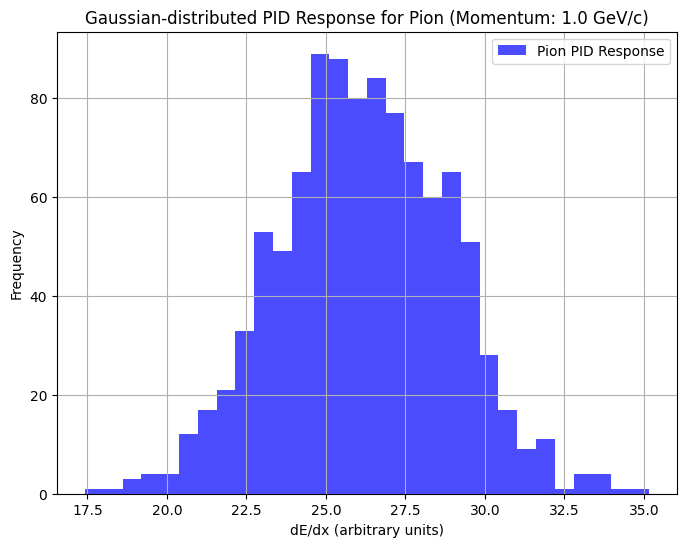

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussian_pid_distribution(momentum, particle_type, n_samples=100, stretch_factor=1):
    """
    Generates and plots Gaussian-distributed PID response values for a given particle type and momentum.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    - n_samples: Number of Gaussian-distributed samples to generate (default = 100)
    - stretch_factor: Stretch factor for the TPC response (default = 1)
    
    Generates:
    - A plot of the Gaussian-distributed PID response values.
    """
    # Generate the Gaussian-distributed PID values
    pid_values = generate_gaussian_pid_list(momentum, particle_type, n_samples, stretch_factor)
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.hist(pid_values, bins=30, color='blue', alpha=0.7, label=f'{particle_type.capitalize()} PID Response')
    
    # Add labels and title
    plt.xlabel('dE/dx (arbitrary units)')
    plt.ylabel('Frequency')
    plt.title(f'Gaussian-distributed PID Response for {particle_type.capitalize()} (Momentum: {momentum} GeV/c)')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Example usage
momentum = 1.0  # Example momentum in GeV/c
particle_type = 'pion'  # Example particle type
n_samples = 1000  # Number of PID values to generate

# Generate and plot the distribution
plot_gaussian_pid_distribution(momentum, particle_type, n_samples, get_stretch_factor(particle_type))


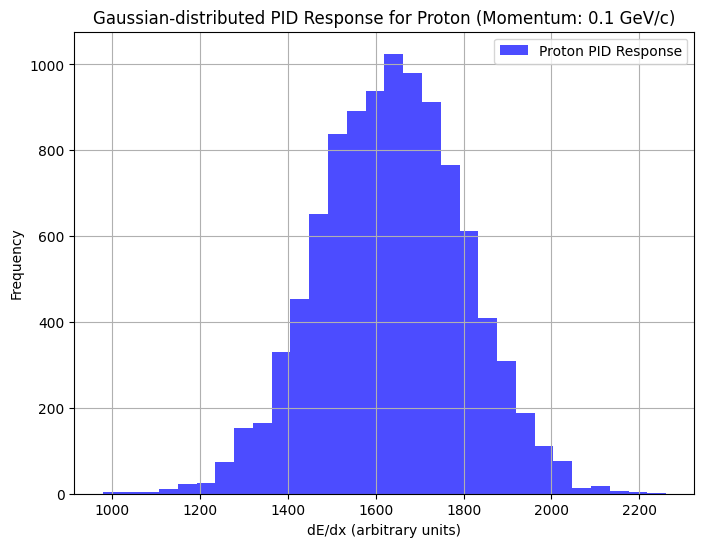

In [19]:
momentum = 0.1  # Example momentum in GeV/c
particle_type = 'proton'  # Example particle type
n_samples = 10000  # Number of PID values to generate

# Generate and plot the distribution
plot_gaussian_pid_distribution(momentum, particle_type, n_samples, get_stretch_factor(particle_type))


Chi-square (χ²) of the fit: 0.00


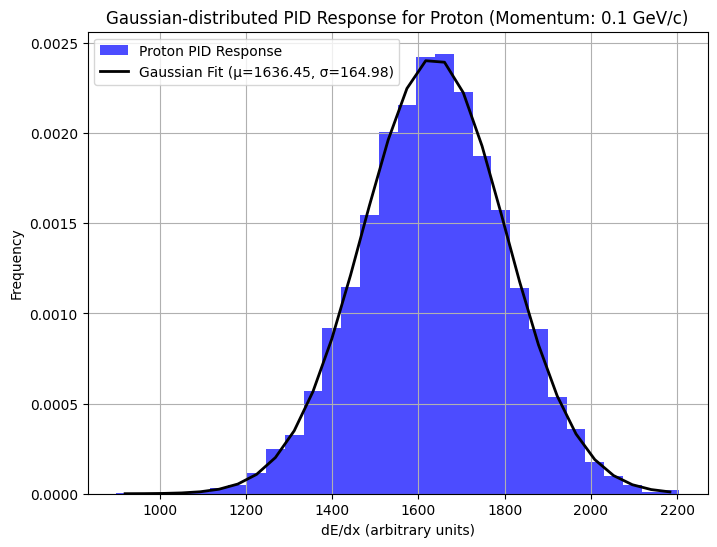

In [20]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

def plot_and_save_gaussian_pid_distribution(momentum, particle_type, n_samples=100, stretch_factor=1):
    """
    Generates, plots, and fits Gaussian-distributed PID response values for a given particle type and momentum.
    Additionally calculates and prints the chi-square value for the Gaussian fit.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    - n_samples: Number of Gaussian-distributed samples to generate (default = 100)
    - stretch_factor: Stretch factor for the TPC response (default = 1)
    
    Returns:
    - The histogram plot with Gaussian fit and chi-square value.
    """
    # Generate the Gaussian-distributed PID values
    pid_values = generate_gaussian_pid_list(momentum, particle_type, n_samples, stretch_factor)
    
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    counts, bin_edges, _ = plt.hist(pid_values, bins=30, color='blue', alpha=0.7, density=True, label=f'{particle_type.capitalize()} PID Response')
    
    # Fit a Gaussian to the data
    mu, std = norm.fit(pid_values)
    
    # Generate the fit curve
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    fit_curve = norm.pdf(bin_centers, mu, std)
    
    # Plot the Gaussian fit
    plt.plot(bin_centers, fit_curve, 'k', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')
    
    # Calculate chi-square
    observed = counts
    expected = fit_curve * np.diff(bin_edges) * np.sum(counts)  # Normalize expected to match the histogram area
    chi2 = np.sum((observed - expected) ** 2 / expected)
    print(f'Chi-square (χ²) of the fit: {chi2:.2f}')
    
    # Add labels and title
    plt.xlabel('dE/dx (arbitrary units)')
    plt.ylabel('Frequency')
    plt.title(f'Gaussian-distributed PID Response for {particle_type.capitalize()} (Momentum: {momentum} GeV/c)')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()
    return plt, mu, std, chi2


momentum = 0.1  # Example momentum in GeV/c
particle_type = 'proton'  # Example particle type
n_samples = 10000  # Number of PID values to generate

# Generate and plot the distribution with Gaussian fit and chi-square
plot, mu, std, chi2 = plot_and_save_gaussian_pid_distribution(momentum, particle_type, n_samples, get_stretch_factor(particle_type))
